# Imports

Import the required components:

In [ ]:
from typing import List, Optional, Union
import dataclasses
import pandas as pd

from evidently.base_metric import InputData
from evidently.base_metric import Metric
from evidently.base_metric import MetricResult
from evidently.model.widget import BaseWidgetInfo
from evidently.renderers.base_renderer import MetricRenderer
from evidently.renderers.base_renderer import default_renderer
from evidently.renderers.html_widgets import CounterData
from evidently.renderers.html_widgets import header_text
from evidently.renderers.html_widgets import plotly_figure

# Understand the architecture

The `metric` is a key component of Evidently. Each `test` uses a metric for calculations. If you want to create a test, you need to create a metric first. Both tests and metrics have `renders` which might look differently. If you are creating metric or test for your internal use, you might skip some steps: e.g., do not create a sophisticated visualization if you do not need it.

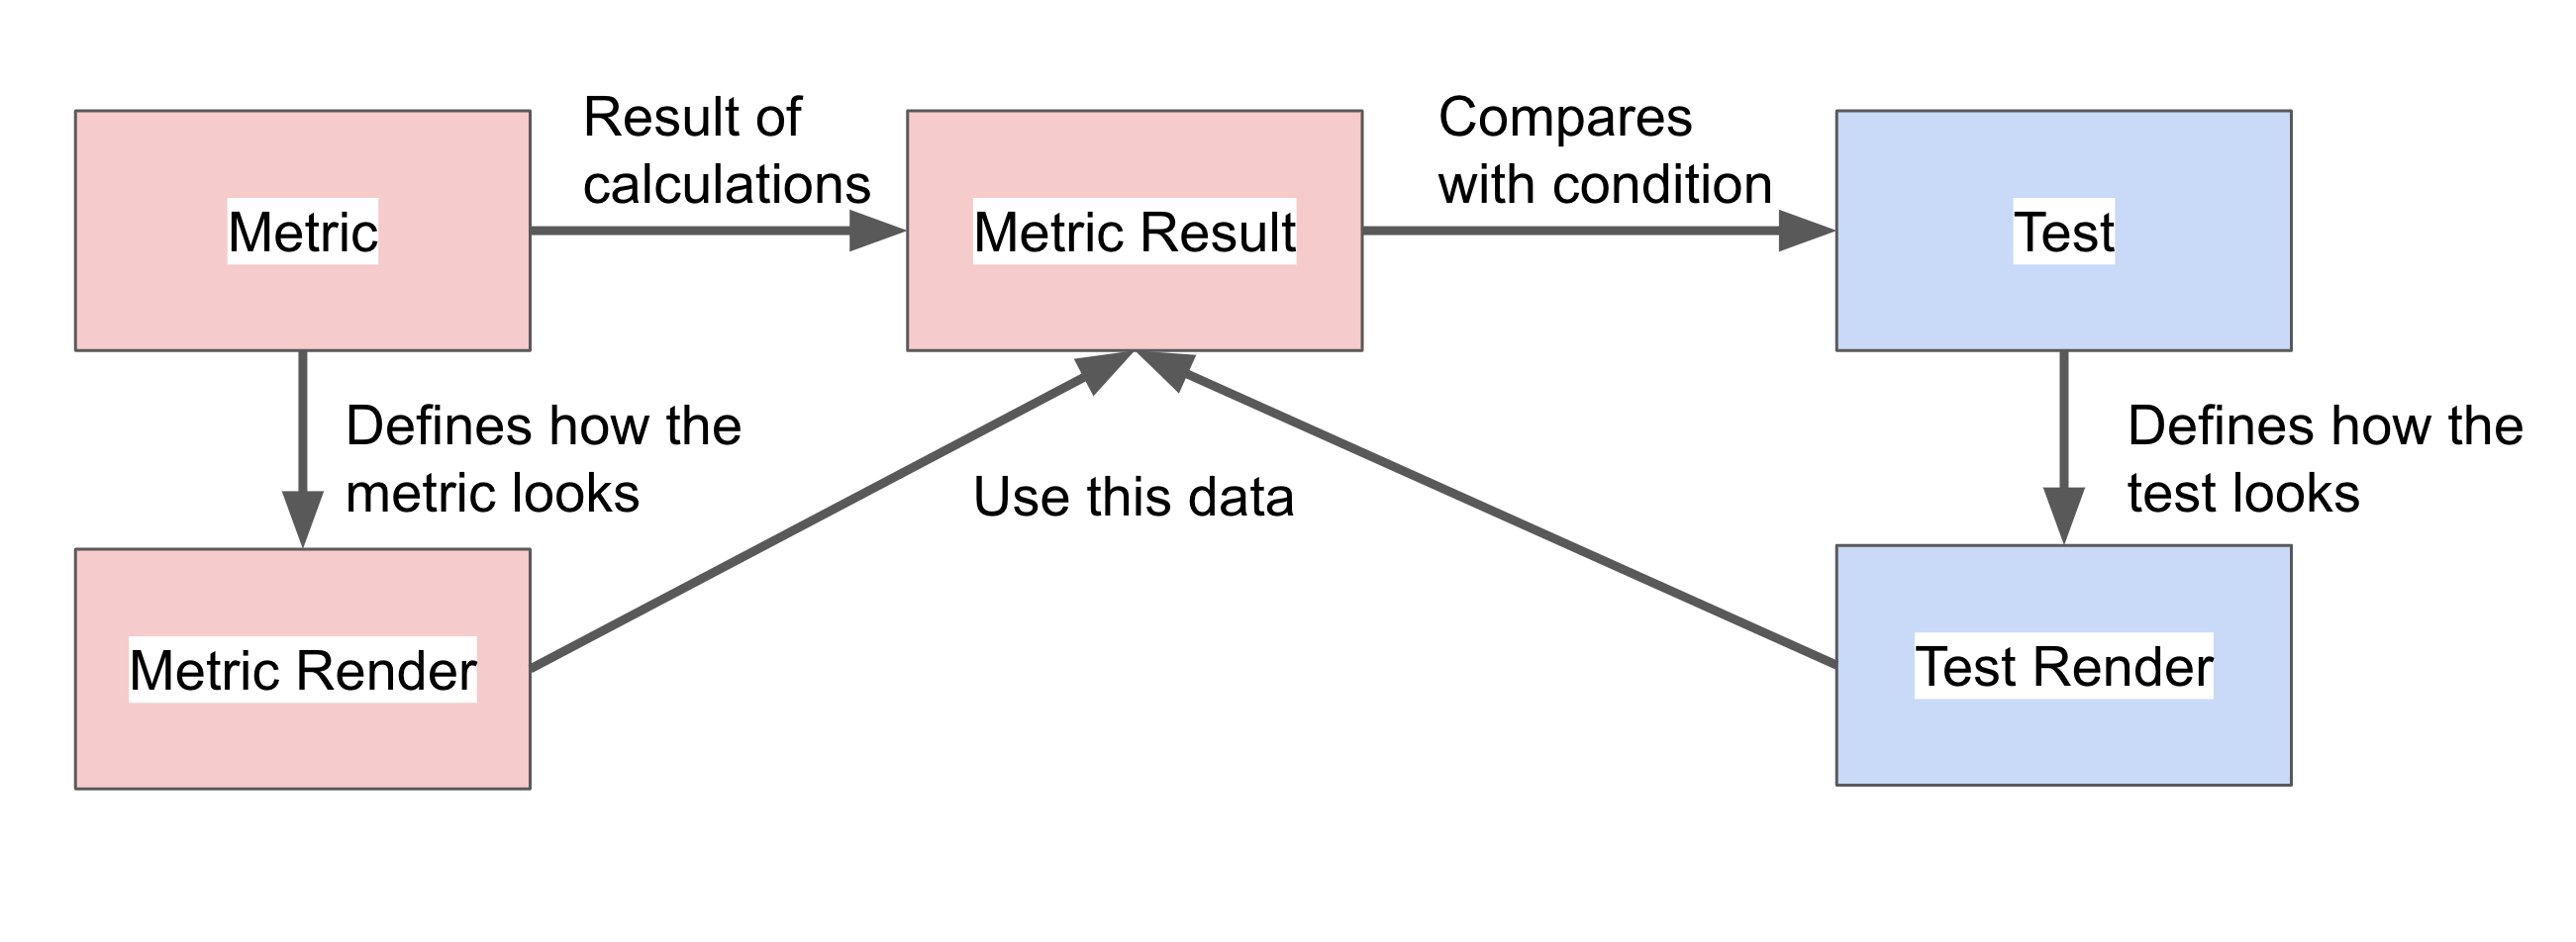

# Create a new metric

Let's imagine you want to create a metric that sums up all the values in a column.

First, you need to define the resulting `dataclass`.



In [ ]:
class MyMetricResult(MetricResult):
    sum_value: float

Then, you need to create the class of the `metric` itself. It should have the `calculate` method which takes `InputData` - a class that contains reference dataset, current dataset and column mapping.


In [ ]:
class MyMetric(Metric[MyMetricResult]):
  column_name: str

  def __init__(self, column_name: str):
    self.column_name = column_name
    super().__init__()

  def calculate(self, data: InputData) -> MyMetricResult:
    metric_value = data.current_data[self.column_name].sum()
    return MyMetricResult(
        sum_value = metric_value
    )


# Define the metric render

Next, you need to define the way the metric will look in the HTML reports or JSON export. Let's make a `render` class!

**Note:** HTML render is optional. You can skip it if you do not plan to use the metric independently, and only want to call it as part of the test.



In [ ]:
@default_renderer(wrap_type=MyMetric)
class MyMetricRenderer(MetricRenderer):
    def render_json(self, obj: MyMetric) -> dict:
        result = dataclasses.asdict(obj.get_result())
        return result

    def render_html(self, obj: MyMetric) -> List[BaseWidgetInfo]:
        metric_result = obj.get_result()
        return [
            # helper function for visualisation. More options here More options avaliable https://github.com/evidentlyai/evidently/blob/main/src/evidently/renderers/html_widgets.py
            header_text(label=f"My metrics value is {metric_result.sum_value}"),
        ]

Here is how the metric output looks if you apply it on a sample data:

In [ ]:
from sklearn import datasets
from evidently import ColumnMapping
from evidently.report import Report

adult_data = datasets.fetch_openml(name='adult', version=2, as_frame='auto')
adult = adult_data.frame

data_drift_dataset_report = Report(metrics=[
    MyMetric(column_name='age')
])

data_drift_dataset_report.run(reference_data=None, current_data=adult)
data_drift_dataset_report

In the previous step, we used a basic visualization. You might want to add more information to the widget: for example, pass the column name, show the metric value for the reference dataset, or add some visualizations (using Plotly).

To do that, you need to get these values in the `metric` class and pass to the `render ` using `MetricResult`.

In [ ]:
from plotly import graph_objs as go


class MyMetricResult(MetricResult):
    feature_name: str
    current_sum_value: float
    x_values_for_hist: list
    y_values_for_hist: list
    reference_sum_value: Optional[float] # reference data could absence so we will have None in that case


class MyMetric(Metric[MyMetricResult]):
  column_name: str

  def __init__(self, column_name: str) -> None:
    self.column_name = column_name
    super().__init__()

  def calculate(self, data: InputData) -> MyMetricResult:
    reference_sum_value = None
    if data.reference_data is not None:
      reference_sum_value = data.reference_data[self.column_name].sum()
    current_sum_value = data.current_data[self.column_name].sum()
    # let's pretend we calculate some data for plot
    x_values_for_hist = [1, 2]
    y_values_for_hist = [2, 4]
    return MyMetricResult(
        feature_name = self.column_name,
        current_sum_value = current_sum_value,
        x_values_for_hist = x_values_for_hist,
        y_values_for_hist = y_values_for_hist,
        reference_sum_value = reference_sum_value
    )


@default_renderer(wrap_type=MyMetric)
class MyMetricRenderer(MetricRenderer):
    def render_json(self, obj: MyMetric, include_render: bool = False,
        include: "IncludeOptions" = None, exclude: "IncludeOptions" = None,) -> dict:
        result = obj.get_result().get_dict(include_render, include, exclude)
        # we don't need plot data here
        result.pop("x_values_for_hist", None)
        result.pop("y_values_for_hist", None)
        return result

    def render_html(self, obj: MyMetric) -> List[BaseWidgetInfo]:
        metric_result = obj.get_result()
        figure = go.Figure(go.Bar(x=metric_result.x_values_for_hist, y=metric_result.y_values_for_hist))

        return [
            header_text(label=f"The sum of '{metric_result.feature_name}' column is {metric_result.current_sum_value} (current)"),
            header_text(label=f"The sum of '{metric_result.feature_name}' column is {metric_result.reference_sum_value} (reference)"),
            plotly_figure(title="Example plot", figure=figure)
        ]

# Use the metric

Here is how you can include the new metric in the Report.




In [ ]:
data_drift_dataset_report = Report(metrics=[
    MyMetric(column_name='age')
])

data_drift_dataset_report.run(reference_data=None, current_data=adult)
data_drift_dataset_report

In [ ]:
data_drift_dataset_report.json()

# Create a new test

If you want to be able to compare the new metric against a defined condition as part of a Test Suite, you need to create a Test.

To make a Test, you need a Metric:

*   The metric calculates the value
*   The test gets the values, and performs the comparison

We already got the metric. Now, let's make a test.

When you create a test, you can also define the default test conditions. They will apply if you call the test "as is" without passing a custom constraint.

In [ ]:
from abc import ABC
from evidently.utils.types import Numeric
from evidently.renderers.base_renderer import TestHtmlInfo
from evidently.renderers.base_renderer import TestRenderer
from evidently.tests.base_test import BaseCheckValueTest
from evidently.tests.base_test import GroupData
from evidently.tests.base_test import GroupingTypes
from evidently.tests.base_test import TestValueCondition

# make a group for test. It used for grouping tests in the report
MY_GROUP = GroupData("my_group", "My Group", "")
GroupingTypes.TestGroup.add_value(MY_GROUP)

class MyTest(BaseCheckValueTest, ABC):
    name = "My test"
    group = MY_GROUP.id

    column_name: str
    # define a metric used for calculation
    _metric: MyMetric

    def __init__(
        self,
        column_name: str,
        eq: Optional[Numeric] = None,
        gt: Optional[Numeric] = None,
        gte: Optional[Numeric] = None,
        is_in: Optional[List[Union[Numeric, str, bool]]] = None,
        lt: Optional[Numeric] = None,
        lte: Optional[Numeric] = None,
        not_eq: Optional[Numeric] = None,
        not_in: Optional[List[Union[Numeric, str, bool]]] = None,
    ):
        self.column_name = column_name
        super().__init__(eq=eq, gt=gt, gte=gte, is_in=is_in, lt=lt, lte=lte, not_eq=not_eq, not_in=not_in)
        self._metric = MyMetric(self.column_name)

    def get_condition(self) -> TestValueCondition:
        # if condition specified like lte=8 or gt=3 etc
        if self.condition.has_condition():
            return self.condition
        # if there is no condition but we have reference and we want to calculate the condition by reference
        ref_result = self._metric.get_result().reference_sum_value
        if ref_result is not None:
          return TestValueCondition(lte=ref_result)
        # if there is no condition, no reference data but we have some idea about the value should be
        return TestValueCondition(gt=0)

    # define the value we will compare against condition
    def calculate_value_for_test(self) -> Numeric:
        return self._metric.get_result().current_sum_value
    # define the way test will look like in a table
    def get_description(self, value: Numeric) -> str:
        return f"The sum of '{self._metric.get_result().feature_name}' column is {self._metric.get_result().current_sum_value}. The test threshold is {self.get_condition()}"

You can add a` render `class for the test as well. This class also should use data from the metric result only.

**Note:** it's optional. You can still use the test if you do not define the render. In this case, Evidently will use the information from the 'get_description' method to show the test output in the preview. However, once you click on "details" there will be no supporting visualization.

In [ ]:
@default_renderer(wrap_type=MyTest)
class MyTestRenderer(TestRenderer):
    def render_json(self, obj: MyTest) -> dict:
        result = super().render_json(obj)
        metric_result = obj._metric.get_result()
        result["parameters"]["condition"] = obj.get_condition().as_dict()
        result["parameters"]["reference_sum_value"] = metric_result.reference_sum_value
        result["parameters"]["current_sum_value"] = metric_result.current_sum_value
        return result

    def render_html(self, obj: MyTest) -> List[BaseWidgetInfo]:
        info = super().render_html(obj)
        metric_result = obj._metric.get_result()
        figure = go.Figure(go.Bar(x=metric_result.x_values_for_hist, y=metric_result.y_values_for_hist))
        info.with_details("", plotly_figure(title="Example plot", figure=figure))
        return info

# Use the new test

Here is how you can include your new test in a Test Suite:



In [ ]:
from evidently.test_suite import TestSuite

my_tests = TestSuite(tests=[
    MyTest(column_name='age')
])

my_tests.run(reference_data=adult[:5000], current_data=adult[5000:10000])
my_tests

# Create a custom report with the new metric

You can combine your new metric with other metrics available in the library in a single report.

In [ ]:
from evidently.metrics import *

data_drift_dataset_report = Report(metrics=[
    MyMetric(column_name='age'),
    ColumnDriftMetric(column_name='age'),
    DatasetMissingValuesMetric(),

])

data_drift_dataset_report.run(reference_data=adult[:5000], current_data=adult[5000:10000])
data_drift_dataset_report

# Create a custom test suite with a new test

It works the same way for tests.

In [ ]:
from evidently.tests import *


my_tests = TestSuite(tests=[
    MyTest(column_name='age'),
    TestNumberOfRowsWithMissingValues(),
    TestNumberOfConstantColumns()

])

my_tests.run(reference_data=adult[:5000], current_data=adult[5000:10000])
my_tests